# Solution method
In this notebook we show how to
1. Set up a heterogeneous-agent block
2. Solve for the steady state
3. Compute the Jacobian
4. Compute linearized impulse responses
5. Compute business cycle statistics (second moments)
6. Compute model likelihood
7. Compute nonlinear impulse responses


## Household Problem
The household problem is as follows:
- if employed
$$V^{E}(a,x,\lambda,\mu) = \underset{a'}{\max\;}\ln(c) - B \frac{\bar{h}^{1+\frac{1}{\gamma}}}{1+\frac{1}{\gamma}} + \beta \mathbb{E} \max \left\{V^{E}(a',x',\lambda',\mu'),V^{N}(a',x',\lambda',\mu') \right\}
$$
such that 
$$c = w(\lambda,\mu)x\bar{h} + (1+r(\lambda,\mu))a - a'
$$
- if unemployed
$$
V^{N}(a,x,\lambda,\mu) = \underset{a'}{\max\;}\ln(c) + \beta \mathbb{E} \max \left\{V^{E}(a',x',\lambda',\mu'),V^{N}(a',x',\lambda',\mu') \right\}
$$
such that 
$$
c = (1+r(\lambda,\mu))a - a'
$$

## 0 Import packages
The first five are standard python packages, the rest contain code we wrote for this project. 

In [27]:
import numpy as np
from numba import njit
from numba import jit
import scipy.optimize as opt
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import time

import mathutils
import het_block as het
import rec_block as rec
from rec_block import recursive
import jacobian as jac
import ks

## 1 Set up heterogeneous-agent block

Here we solve the household problems by applying Carroll's endogenous grid method (henceforth EGM). This makes use of the optimality condition coming from the household's first order conditions. Denoting
$$
V(a,x,\lambda,\mu) := \max\{V^{E}(a,x,\lambda,\mu),V^{N}(a,x,\lambda,\mu)\}
$$

we can rewrite the two Bellmans above, subject to the same constraints, as

$$V^{E}(a,x,\lambda,\mu) = \underset{a'}{\max\;}\ln(c) - B \frac{\bar{h}^{1+\frac{1}{\gamma}}}{1+\frac{1}{\gamma}} + \beta \mathbb{E} V(a',x',\lambda',\mu')
$$

$$
V^{N}(a,x,\lambda,\mu) = \underset{a'}{\max\;}\ln(c) + \beta \mathbb{E} V(a',x',\lambda',\mu')
$$

and this leads us to the first order conditions:

$$
\frac{1}{c} = \beta \mathbb{E} V^{i}_{a'}(a',x',\lambda',\mu'),
$$

and the envelope condition

$$
V^{i}_{a} = \frac{1+r(\lambda,\mu)}{c}.
$$

* Backward iteration (using EGM):
  1. Start with $V_{a'}(a',x',\lambda',\mu')$, tomorrow's marginal value of assets
  2. Determine the household policies that are consistent (optimally) with $V_{a'}(a',x',\lambda',\mu')$
  3. Return the updated $V_{a}^{i}(a,x,\lambda,\mu)$, today's marginal value of assets for type $i\in\{E,N\}$
* Note: in Auclert et al.'s codes the ordering of the inputs and outputs are important for internal consistency within the algorithm.

Because of the max operator (next period employment choice), this problem is more complex than the simple consumption-savings problem. Namely, we solve the employed and unemployed problems separately, ignoring the max operator, and determine the cutoffs  in a third step.

In [22]:
def backward_VFI(VE_p, VU_p, Us, Pi_p, a_grid, e_grid, params, w, h):
    """Computes one backward iteration in the VFI algorithm
    Parameters
    ----------
    VE_p     : array (S*A), next period value function for employed
    VU_p     : array (S*A), next period value function for unemployed
    Us       : array (S*S), utility for all possible combinations of assets 
               today and tomorrow
    Pi_p     : array (S*S), Markov matrix for skills tomorrow
    a_grid   : array (A), asset grid
    e_grid   : array (A), skill grid
    params   : dictionary with useful parameters
    w        : scalar, wage
    h        : hours worked

    Returns
    ----------
    V  : array (S*A), marginal value of assets today
    a  : array (S*A), asset policy today
    c  : array (S*A), consumption policy today
    """
    #getting parameters
    beta = params['beta']
    w = params['w']
    r = params['r']
    h = params['h']
    N = params['N']
    M = params['M']

    #initializing next period V
    V = np.zeros([N,M])
    apol = np.zeros([N,M])
    cpol = np.zeros([N,M])

    ExpV = np.maximum(VE_p,VU_p)


    tomax = Us + np.tile(ExpV @ (beta * Pi_p),(N,1,1))    
    max_locs = np.argmax(tomax,axis=1)
    #apol = a_grid[max_locs]
    #cpol = w*e_grid*h + - apol + (1+r)*a_grid[:,np.newaxis]
    #V = np.amax(tomax,axis=1)
    for i in range(M):                    
        apol[:,i] = a_grid[max_locs[:,i]]
        cpol[:,i] = w*e_grid[i]*h + (1+r)*a_grid - apol[:,i]
        V[:,i] = np.max(tomax[:,:,i],axis=1)        
        
    return V, apol, cpol

Next we solve for the steady state policy functions by repeatedly applying the backward iteration function until convergence.

In [32]:
def pol_ss(Pi, e_grid, a_grid, params, w, h, tol=1E-8, maxit=5000):
    """Find steady-state policy functions."""        
    
    #getting parameters
    beta = params['beta']
    gamma = params['gamma']    
    r = params['r']
    B = params['B']
    N = params['N']
    M = params['M']

    #Computing consumption in each scenario
    a_tom = np.tile(a_grid,(N,1))
    a_tod = np.transpose(a_tom)
    atmp = (1+r)*a_tod - a_tom    
    Cs = np.tile(w*e_grid*h,(N,N,1)) +  np.repeat(atmp[:, :, np.newaxis], M, axis=2)
    #imposing -Inf utility whenever there is negative consumption
    neg_c = (Cs <= 0)
    Cs[neg_c] = 10
    Us = np.log(Cs) - B*(h**(1 + 1/gamma))/(1+ 1/gamma)
    Us[neg_c] = -1e10

    #initializing VFI 
    dist = np.inf   #improvement step
    it = 0          #iteration number


    VE_p = np.zeros([N,M])     #initializing value function for employed
    VU_p = np.zeros([N,M])     #initializing value function for employed

    while dist>tol and it<maxit:        
        VE, apolE, cpolE = backward_VFI(VE_p, VU_p, Us, Pi, a_grid, e_grid, params, w, h)
        VU, apolU, cpolU = backward_VFI(VE, VU_p, Us, Pi, a_grid, e_grid, params, w, 0)

        V_p = np.maximum(VE_p,VU_p)    
        dist = np.amax(abs(V_p - np.maximum(VE,VU)))
        VE_p = np.copy(VE)
        VU_p = np.copy(VU)
        if it%100==0:
            print("Iteration # " + str(it) + "- step = " + str(dist))
        it = it+1
    #global policy and value functions ()
    a = apolU*(VU_p>=VE_p) + apolE*(VU_p<VE_p)
    c = cpolU*(VU_p>=VE_p) + cpolE*(VU_p<VE_p)
    V = VU_p*(VU_p>=VE_p) + VE_p*(VU_p<VE_p) 
    return V, a, c

In [36]:
alpha = 0.64        #labor share
beta = 0.98267      #discount factor 
gamma = 0.4         #Frisch elasticity
w = 585             #wage
r = 0.01            #interest rate
amax=5000           #maximal assets
amid = 2000         #up to here lots of points 
amin=-2             #borrowing limit
N = 2000            #number of grid points for assets
M = 2               #number of grid points for productivity
h = 1/3             #hours worked
B = 166.3           #disutility of labor

params = {'alpha':alpha,
          'beta':beta,
          'gamma':gamma,
          'w':w,
          'r':r,
          'amax':amax,
          'amid':amid,
          'amin':amin,
          'N':N,
          'M':M,
          'h':h,
          'B':B}


# set up grid
a_grid = np.linspace(amin, amid, num=int(N/2))

a_grid = np.append(a_grid,np.linspace(amid,amax, num=int(N/2)))


#state transition matrix
pUE=0.5
pEU=0.038
b=0.15
L = pUE / (pUE + pEU)  # labor endowment normalized to 1
e_grid = np.array([b, 1 - (1 - L) / L * b])
Pi = np.array([[1 - pUE, pUE], [pEU, 1 - pEU]])

Next, we use the steady state policies to compute the stationary distribution. This does not involve any simulation: instead, when the policy `a` is in between two gridpoints, we proportionally assign mass between those two gridpoints. (See for instance [Young (2010)](https://www.sciencedirect.com/science/article/pii/S0165188909001316).) This code is generic for models with one endogenous state and thus relegated to `mathutils.py`.

Now we're ready to put all these steps together in a single function, which gives the complete partial equilibrium behavior of the household sector in steady state: when fed with the Markov transition matrix, the grids, the interest rate, and so on, it gives the steady-state distribution, aggregate and individual policies, and so on.

In [25]:
def household_ss(Pi, a_grid, e_grid, params):
    """Solve for steady-state policies and distribution. Report results in dict."""
    #getting parameters
    beta = params['beta']
    w = params['w']
    r = params['r']
    B = params['B']
    h = params['h']
    N = params['N']
    M = params['M']

    # solve ha block
    V, a, c = pol_ss(Pi, e_grid, a_grid, params, w, h)
    D = mathutils.dist_ss(a, Pi, a_grid)

    # return dictionary with results and inputs
    inputs = {'Pi': Pi, 'a_grid': a_grid, 'e_grid': e_grid, 'r': r, 'w': w, 'beta': beta}
    results = {'D': D, 'V': V, 'a': a, 'c': c, 'A': np.vdot(D, a), 'C': np.vdot(D, c)}

    return {**inputs, **results}

In [ ]:
t0 = time.time()
ssres = household_ss(Pi, a_grid, e_grid, params)
t1 = time.time()
total = t1-t0
print(total)

Iteration # 0- step = 16.82069214778574


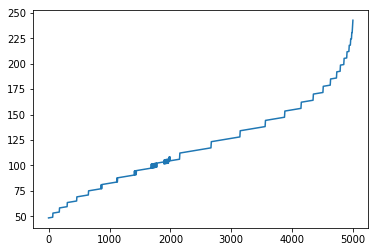

In [35]:
#ssres['D'].shape
plt.plot(a_grid,ssres['c'][:,1])

## 2 Calibrating the steady state
Next, we calibrate the HA block in general equilibrium. The calibration exercise amounts to finding the right discount factor to hit a targeted annual interest rate conditional on all the other exogenous parameters. We use Brent's method, an efficient way to solve for a root on an interval, from the `scipy.optimize` package to do so.

Although additional efficiency gains would be possible here (for instance, by updating our initial guesses for policy and distribution along the way), we will not implement them, since they are not our focus here.

Our default values depart slightly from the canonical Krusell-Smith calibration, mainly by assuming a lower capital share, which leads to lower steady-state capital and more interesting behavior thanks to higher MPCs.

In [12]:
def ks_ss(lb=0.98, ub=0.999, r=0.01, eis=1, delta=0.025, alpha=0.11, b=0.15, pUE=0.5, pEU=0.038, nA=100, amax=20):
    """Solve steady state of full GE model. Calibrate beta to hit target for interest rate."""
    # set up grid
    a_grid = mathutils.agrid(amax=amax, n=nA)
    L = pUE / (pUE + pEU)  # labor endowment normalized to 1
    e_grid = np.array([b, 1 - (1 - L) / L * b])
    Pi = np.array([[1 - pUE, pUE], [pEU, 1 - pEU]])

    # solve for aggregates analitically
    rk = r + delta
    Z = (rk / alpha) ** alpha / L ** (1 - alpha)  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha)) * L
    Y = Z * K ** alpha * L ** (1 - alpha)
    w = (1 - alpha) * Z * (alpha * Z / rk) ** (alpha / (1 - alpha))

    # solve for beta consistent with this
    beta_min = lb / (1 + r)
    beta_max = ub / (1 + r)
    beta, results = opt.brentq(lambda bet:
                               household_ss(Pi, a_grid, e_grid, r, w, bet, eis)['A'] - K,
                               beta_min, beta_max, full_output=True)
    if not results.converged:
        raise ValueError('Steady-state solver did not converge.')

    # extra evaluation to report variables
    ss = household_ss(Pi, a_grid, e_grid, r, w, beta, eis)
    mpc = mathutils.mpcs(ss['c'], ss['a_grid'], ss['r'])
    ss.update({'mpc': mpc, 'MPC': np.vdot(ss['D'], mpc),
               'w': w, 'Z': Z, 'K': K, 'L': L, 'Y': Y, 'alpha': alpha, 'delta': delta,
               'goods_mkt': Y - ss['C'] - delta * K})

    return ss

Let's solve for the steady state using our default calibration, and plot the consumption policy function for unemployed and employed households as a function of assets.

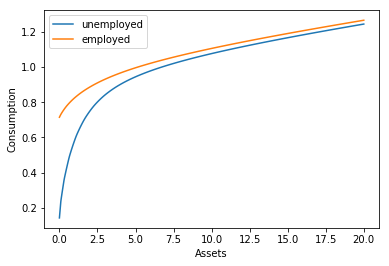

In [14]:
ss = ks_ss()
plt.plot(ss['a_grid'], ss['c'][0,:], label='unemployed')
plt.plot(ss['a_grid'], ss['c'][1,:], label='employed')
plt.legend()
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()

### Speed of steady-state solution
Our backward and forward iterations use Numba, [a just-in-time compilation library](https://numba.pydata.org/numba-doc/dev/user/5minguide.html) that translates pure numerical Python to fast machine code. The first time functions are run, there is some compilation lag, similar to (but much less time-consuming than) compilation time in languages like C++, Fortran, and Julia.

Now that we have run everything once, we can time our steady-state calibration routine. An efficient steady state is not the focus of this notebook or our methods, but it is nice to see that performance is still quite good:

In [7]:
%time ss = ks_ss()

CPU times: user 167 ms, sys: 2.69 ms, total: 169 ms
Wall time: 169 ms


Indeed, this simple example is so fast that increasing the number of asset gridpoints from 100 to 1000 (which has no visible effect on the solution) only doubles the time.

In [8]:
%time _ = ks_ss(nA=1000)

CPU times: user 336 ms, sys: 2.87 ms, total: 339 ms
Wall time: 341 ms


### Checking Walras's law
It's always useful to check whether Walras's law holds. The omitted goods market clearing condition reads as 
$$
Y_t = \mathcal{C}_t(\{r_t, w_t\}) + K_t - (1 - \delta) K_{t-1}
$$
and is reported by the `ks_ss` function above.

In [9]:
print(ss['goods_mkt'])

-4.806331443951706e-10


## 3 Jacobians
Jacobians are the key concept to solve and to estimate models in sequence space. Each model block has its own Jacobians, which can be combined via the chain rule into Jacobians for the complete model. A Jacobian in a $T$-dimensional (truncated) sequence space is a $T \times T$ matrix of the form
$$
\frac{d Y}{d Z} = 
\begin{pmatrix}
\frac{d Y_0}{d Z_0} & \frac{d Y_0}{d Z_1} & \dots & \frac{d Y_0}{d Z_T} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d Y_T}{d Z_0} & \frac{d Y_T}{d Z_1} & \dots & \frac{d Y_T}{d Z_T}
\end{pmatrix}
$$
evaluated at the steady state.

### 3.1 Recursive blocks
To build intuition, let's start with the firm block. In our code, recursive blocks are specified as regular Python functions  endowed with the decorator ``@recursive``. In the body of the function, we simply implement the corresponding equilibrium conditions. The decorator turns the function into an instance of ``RecursiveBlock``, a simple class with methods to evaluate itself in steady state and along a transition path. Notice the use of K(-1) to denote 1-period lag, like Dynare. In general, one can write (-s) and (+s) to denote s-period lags and leads. 

In [10]:
@recursive
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

Let's take a look at the Jacobian $dY/dZ$, which the `rec.all_Js` function computes numerically via symmetric differencing.

`rec.all_Js` reports the Jacobians it calculates as a nested Python dictionary ("dict"), where the first level is the output variable and the second level is the input variable.

In [11]:
J_firm = rec.all_Js(firm, ss, T=5, shock_list=['K', 'Z'])
print(J_firm['Y']['Z'])

[[1.06265622 0.         0.         0.         0.        ]
 [0.         1.06265622 0.         0.         0.        ]
 [0.         0.         1.06265622 0.         0.        ]
 [0.         0.         0.         1.06265622 0.        ]
 [0.         0.         0.         0.         1.06265622]]


The Jacobian is diagonal because the production function does not depend on leads or lags of productivity. Such sparsity is of course very common for simple blocks, and we wrote `rec_block.py` to take advantage of it.

In principle, one could calculate a Jacobian between each input-output pair. In practice, it only makes sense to do so with respect to endogenous variables and shocks, hence the `shock_list` option. In this model, capital and TFP are the only inputs that will ever change.

### 3.2 HA blocks
HA blocks have more complicated Jacobians, but there's a regular structure that we can exploit to calculate them very quickly. For a formal description, please see the beamer slides.

The tools for dealing with Jacobians of HA blocks are in `het_block.py`. At the end of the day, we'll be able to call a single function, much like `rec_block.all_Js` above. Note that the shocked inputs are specified as a nested dict. This may look like an unnecessarily complicated formulation for now, but it pays off handsomely in richer models, since it allows us to compute Jacobians with respect to shocks that change several multidimensional inputs to the HA block.

In [12]:
J_ha = het.all_Js(backward_iterate, ss, T=5, shock_dict={'r': {'r': 1}, 'w': {'w': 1}})
print(J_ha['c']['r'])

[[ 0.12147336 -0.75482959 -0.72124726 -0.68942363 -0.65913146]
 [ 0.11879385  0.1536579  -0.72435556 -0.69235905 -0.6620055 ]
 [ 0.11589095  0.1498586   0.18316819 -0.69632319 -0.66571357]
 [ 0.11283361  0.14586955  0.17838157  0.21030918 -0.67049205]
 [ 0.10968938  0.14175432  0.17341186  0.20461724  0.23530525]]


Notice that this matrix is no longer sparse. This generally the case for HA blocks. The Bellman equation implies that policies are forward-looking, and then aggregates are also backward-looking due to persistence coming via the distribution.

But how is the sausage made? The code behind `het.all_Js` is displayed below. First, we process the backward iteration function and interpolate the steady-state policy. Then we begin the four key steps discussed on page 22 of the Beamer slides.

In step 1, we calculate $\{\mathcal{Y}_s, \mathcal{D}_s\}$ using the `backward_iteration` function. In step 2, we calculate the prediction vectors $\{\mathcal{P}_s\}$ using the `forward_iteration_transpose` function. In step 3, we combine these to make the "fake news matrix" using the `build_F` function, and in step 4 we convert this to the actual Jacobian using the `J_from_F` function. We obtain Jacobians for each pair of outcomes and shocks.

We invite you to dive into `het_block.py` to investigate the code in more detail.

In [13]:
def all_Js(back_step_fun, ss, T, shock_dict):
    # preliminary a: process back_step_funtion
    ssinput_dict, ssy_list, outcome_list, V_name = extract_info(back_step_fun, ss)

    # preliminary b: get sparse representation of asset policy rule
    a_pol_i, a_pol_pi = mathutils.interpolate_coord(ss['a_grid'], ss['a'])

    # step 1: compute curlyY and curlyD (backward iteration) for each input i
    curlyYs, curlyDs = dict(), dict()
    for i, shock in shock_dict.items():
        curlyYs[i], curlyDs[i] = backward_iteration(shock, back_step_fun, ssinput_dict, ssy_list, outcome_list,
                                                    V_name, ss['D'], ss['Pi'], a_pol_i, ss['a_grid'], T)

    # step 2: compute prediction vectors curlyP (forward iteration) for each outcome o
    curlyPs = dict()
    for o, ssy in zip(outcome_list, ssy_list[1:]):
        curlyPs[o] = forward_iteration_transpose(ssy, ss['Pi'], a_pol_i, a_pol_pi, T)

    # step 3-4: make fake news matrix and Jacobian for each outcome-input pair
    J = {o: {} for o in outcome_list}
    for o in outcome_list:
        for i in shock_dict:
            F = build_F(curlyYs[i][o], curlyDs[i], curlyPs[o])
            J[o][i] = J_from_F(F)

    # report Jacobians
    return J

## 4 Linearized dynamics using Jacobians
Recall that we reduced the model to a single equation $H$
$$
H_t(K, Z) \equiv \mathcal{K}_t\left(\left\{\alpha Z_s \left(\frac{K_{s-1}}{\pi l}\right)^{\alpha-1} - \delta, (1-\alpha) Z_s \left(\frac{K_{s-1}}{\pi l}\right)^{\alpha}\right\}\right) - K_t = 0.
$$
to be solved for $K$ given any $Z$.

This is the composition of the household capital supply function $\mathcal{K}$ with the interest rate $r(K_{t-1}, Z_t) = \alpha Z_t \left(\frac{K_{t-1}}{\pi l}\right)^{\alpha-1} - \delta$ and wage $w(K_{t-1}, Z_t) = (1-\alpha) Z_t \left(\frac{K_{t-1}}{\pi l}\right)^{\alpha}$ functions.

### 4.1 Algorithm
We will obtain a linear characterization of all impulse responses following the four-part procedure on page 13 of the beamer slides. We'll do so for the steady state we've already solved, which has information contained in `ss`, and a 300-period truncation horizon.

#### Step 1: For each block, obtain Jacobians of outputs with respect to inputs
Here, we only have two blocks: the firm and household blocks. Getting these Jacobians is quite quick, even for the HA block.

In [14]:
T=300

# firm Jacobian: r and w as functions of Z and K
%time J_firm = rec.all_Js(firm, ss, T, ['K', 'Z'])

# household Jacobian: curlyK (called 'a' for assets by J_ha) as function of r and w
J_ha = het.all_Js(backward_iterate, ss, T, {'r': {'r': 1}, 'w': {'w': 1}}) # compile burn-in
%time J_ha = het.all_Js(backward_iterate, ss, T, {'r': {'r': 1}, 'w': {'w': 1}})

CPU times: user 2.25 ms, sys: 3.13 ms, total: 5.38 ms
Wall time: 3.92 ms
CPU times: user 120 ms, sys: 4.4 ms, total: 124 ms
Wall time: 82.4 ms


#### Step 2: Compose Jacobians along the computational graph
Here, we manually apply the chain rule to calculate Jacobians of household $\mathcal{K}$ with respect to $K$ and $Z$, by composing `J_ha` (which maps $r$ and $w$ to $\mathcal{K}$) with `J_firm` (which maps $K$ and $Z$ to $r$, $w$, and $Y$).

In [15]:
J_curlyK_K = J_ha['a']['r'] @ J_firm['r']['K'] + J_ha['a']['w'] @ J_firm['w']['K']
J_curlyK_Z = J_ha['a']['r'] @ J_firm['r']['Z'] + J_ha['a']['w'] @ J_firm['w']['Z']

A single application of the chain rule can also be automated using the `jac.compose_jacobians` function, which gives 

In [16]:
J_curly_K = jac.compose_jacobians(J_firm, J_ha)
np.array_equal(J_curly_K['a']['Z'], J_curlyK_Z)

True

As we will see in the HANK notebook, for more advanced cases there is a `jac.chain_jacobians` function that can automate the process of chaining together arbitrarily many Jacobians.

Now, we will combine `J_curlyK_K` and `J_curlyK_Z` with the firm Jacobians to get a single nested dict with the Jacobians of everything with respect to $K$ and $Z$:

In [17]:
J = {**J_firm, 'curlyK': {'K' : J_curlyK_K, 'Z' : J_curlyK_Z}}

#### Step 3: Invert $H_K$ to obtain impulse response $dK=-H_K^{-1}H_ZdZ$
Now we need to get the Jacobians of our equation $H(K,Z)$, which fully characterizes equilibrium, with respect to $K$ and $Z$. Once we have these, the implicit function theorem gives us the endogenous capital $dK=-H_K^{-1}H_ZdZ$ response to any exogenous shock $dZ$.

Recall that $H$ equals household capital supply $\mathcal{K}$ minus firm capital $K$, so that we can get the Jacobians almost immediately from what we have already calculated.

In [18]:
H_K = J['curlyK']['K'] - np.eye(T)
H_Z = J['curlyK']['Z']

We define $G_K \equiv -H_K^{-1}H_Z$ to be the matrix mapping from any $dZ$ to the corresponding $dK$:

In [19]:
G = {'K': -np.linalg.solve(H_K, H_Z)} # H_K^(-1)H_Z

#### Step 4: Get all other impulses
In `J`, we have Jacobians of $r,w,Y$ with respect to both $Z$ and $K$. If there is a shock to $Z$, we can decompose the change in $r,w,Y$ into a "direct" effect from $dZ$ and an "indirect" effect from the induced change $dK$.

We apply the chain rule to the latter to get matrices $G_r, G_w, G_Y$ mapping any $dZ$ to the corresponding $dr,dw,dY$:

In [20]:
G['r'] = J['r']['Z'] + J['r']['K'] @ G['K']
G['w'] = J['w']['Z'] + J['w']['K'] @ G['K']
G['Y'] = J['Y']['Z'] + J['Y']['K'] @ G['K']

The `G` dict characterizes the full linearized dynamics of aggregate variables $K, r, w, Y$ in response to *any* perturbation to $Z$.

If we want the linearized dynamics of other variables, e.g. consumption, all we need is to get get the Jacobian from the block in which these are calculated, and then compose it with the `G` of its inputs. It turns out that consumption was already reported in `J_ha`, so we just need to write:

In [21]:
G['c'] = J_ha['c']['r'] @ G['r'] + J_ha['c']['w'] @ G['w']

If we wanted to trace the evolution of the household distribution or policy functions for a particular shock, then we could feed in the results to `household_td`, defined below.

### 4.2 Results
What do the impulse responses in this model look like? The beauty of our method is that, now that we have the `G`, we can compute impulse responses to any shock almost instantaneously -- it's just matrix multiplication!

Let's first consider shocks to $Z$ with different persistences, all normalized so that they have a 1% initial impact, and plot the interest rate response to each.

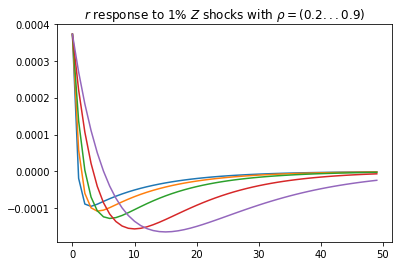

In [22]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ = 0.01*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dr = G['r'] @ dZ
plt.plot(dr[:50, :])
plt.title(r'$r$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.show()

Now let's consider 10,000 different values of rho, for which we can still calculate all $r$ impulse responses almost instantaneously.

In [23]:
rhos = np.linspace(0.1, 0.9, 10000)
dZ = 0.01*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
%time dr = G['r'] @ dZ

CPU times: user 82.3 ms, sys: 23.2 ms, total: 105 ms
Wall time: 57.1 ms


The time taken here differs from run to run, but in the current run (like all runs on a personal laptop) it takes 60 milliseconds of "wall time" to compute 10,000 impulse responses means that each impulse response takes less than **6 microseconds**. "CPU time" is slightly higher because mild parallelization on two cores is used by the built-in matrix multiplication implementation. By contrast, typical impulse response calculations in heterogeneous agent models in the literature take at least a minute, so this method is more than **10 million** times faster as a way of calculating individual impulse responses.

Although this may seem like an extreme example, repeated calculations of this form are quite useful in the most computationally demanding applications, like estimation (as we will see later).

Another important feature of our sequence space methodology is that it is easy to calculate the response to shocks that are difficult to cast into recursive form, like news shocks.

For example, calculating the response to a news shock where $Z$ is expected to increase at a specific period in the future is trivial -- in fact, that's exactly what the columns of the $G$ matrix are. Below we plot the capital responses to news shocks of $Z$ increases at periods 5, 10, 15, 20, and 25.

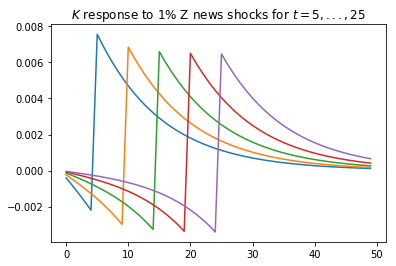

In [24]:
dZ = 0.01*(np.arange(T)[:, np.newaxis] == np.array([5, 10, 15, 20, 25]))
dK = G['K'] @ dZ
plt.plot(dK[:50])
plt.title('$K$ response to 1% Z news shocks for $t=5,...,25$')
plt.show()

## 5 Second moments
Thanks to certainty equivalence, calculating linear impulse responses to shocks gives us an $MA(\infty)$ representation of equilibrium as a function of the history of shocks -- or, more accurately, an $MA(T)$ representation, where $T$ is our truncation horizon. If we know the second moments of the shocks, then we can use this representation to fully characterize the second moments of various outcomes. This computation can be done in a highly efficient way, without any need for simulation.

### 5.1 One-shock case
For instance, following slides 35-36, suppose there is a single i.i.d. shock $\epsilon$ with variance $\sigma^2$, for which we have a $MA(T)$ representation of any outcome $y$ of the form:
$$
y_t = \sum_{k=0}^{T} \theta_k^y \epsilon_{t-k}
$$
Then covariances between outcomes $y$ and $x$ take the form
$$
\text{Cov}(y_t,x_{t+l})= \sigma^2\sum_{k=0}^{T-l} \theta_k^{y} \theta_{k+l}^{x} \tag{Cov}
$$
To apply this, suppose that in the Krusell-Smith model we have an AR(1) process for deviations $dZ$ of productivity taking the form
$$
dZ_t = \rho dZ_{t-1} + \epsilon_t
$$
We can write this as an $MA(\infty)$:
$$
dZ_t = \sum_{k=0}^\infty \rho^k\epsilon_{t-k}
$$
and then, truncating at $T$, compute the endogenous sequences that result from this shock. 

Let's do this for $\rho=0.8$ for the economy we've already solved, calculating $Y$, $C$, and $K$:

In [25]:
dZ = 0.8**(np.arange(T))
dY, dC, dK = G['Y'] @ dZ, G['c'] @ dZ, G['K'] @ dZ

Suppose that we want to calculate $\text{Cov}(dZ_t, dY_{t+2})$, the covariance between productivity and output two periods later. Then we can apply formula (Cov) above to these, assuming that $\sigma=0.02$ for now, obtaining a covariance of roughly 0.00088:

In [26]:
sigma = 0.02
sigma**2*sum(dZ[t]*dY[t+2] for t in range(T-2))

0.000880348005530467

If we want to be slightly more ambitious, let's stack these four series, $dZ, dY, dC, dK$, into a single $T\times 4$ matrix $dX$.

In [27]:
dX = np.stack([dZ, dY, dC, dK], axis=1)
dX.shape

(300, 4)

Then we can write a function that calculates all pairwise covariances for any lag $l$ simultaneously using the same method:

In [28]:
def covariances_naive(dX, sigma, l):
    return sigma**2*sum(dX[t,:,np.newaxis]*dX[t+l,np.newaxis,:] for t in range(T-l))

and verify that it gives the same answer for $\text{Cov}(dZ_t, dY_{t+2})$:

In [29]:
%time covariances_naive(dX, sigma, 2)[0, 1]

CPU times: user 3.94 ms, sys: 169 µs, total: 4.11 ms
Wall time: 2.59 ms


0.000880348005530467

**More efficient method using the Fast Fourier Transform.** Note, however, that approach takes a few milliseconds to calculate autocovariances at each lag. We could make the function much more efficient by writing it using Numba, but if we want *all* the covariances simultaneously -- for instance, for the estimation exercise we'll see later -- then this will still not be efficient enough.

Fortunately, there is a simple way to use the Fast Fourier Transform to perform exactly the same calculation at all lags simultaneously in an extremely efficient way, by passing to the (discrete) frequency domain before applying the covariance function, and then passing back. This is implemented in the following function.

In [30]:
def all_covariances_oneshock(dX, sigma, T):
    dft = np.fft.rfftn(dX, s=(2*T-2,), axes=(0,))
    total = sigma**2*(dft.conjugate()[:,:,np.newaxis]*dft[:,np.newaxis,:])
    return np.fft.irfftn(total, s=(2*T-2,), axes=(0,))[:T]

Now let's see how long it takes to simultaneously calculate covariances for *all* lags up to $T$.

In [31]:
%time Sigma = all_covariances_oneshock(dX, sigma, T)
Sigma.shape

CPU times: user 14.5 ms, sys: 6.8 ms, total: 21.3 ms
Wall time: 30.9 ms


(300, 4, 4)

This is wildly more efficient: compared to before when we looked at a given lag, it now takes a similar magnitude of time to calculate the covariance matrices *at all lags simultaneously*! (Indeed, it is so efficient that the `%time` command overstates the cost, as it is prone to do when we're dealing with just a few milliseconds. `%timeit` gives a more accurate measure but takes longer to run.)

We can verify that it gives exactly the same answers as our previous method by looking at the covariance $\text{Cov}(dX_t, dX_{t+l}')$ at a given lag, say $l=5$.

In [32]:
Sigma[5, ...]

array([[0.00036409, 0.00052289, 0.00049747, 0.00381359],
       [0.0004159 , 0.0006114 , 0.00060909, 0.00472266],
       [0.00018809, 0.00031092, 0.00037503, 0.00302936],
       [0.00103549, 0.00185359, 0.00247514, 0.02036104]])

In [33]:
covariances_naive(dX, sigma, 5)

array([[0.00036409, 0.00052289, 0.00049747, 0.00381359],
       [0.0004159 , 0.0006114 , 0.00060909, 0.00472266],
       [0.00018809, 0.00031092, 0.00037503, 0.00302936],
       [0.00103549, 0.00185359, 0.00247514, 0.02036104]])

### 5.2 Multiple-shock case
Now that we've successfully analyzed the case of a single shock, let's generalize slightly to the case of multiple shocks, again following the slides. Suppose there are multiple i.i.d. shocks $\epsilon^s$ with variances $\sigma^2_s$, in which we have an $MA(T)$ representation for outcomes $y_t$ of the form
$$
y_t = \sum_{s=1}^S \sum_{k=0}^{T} \theta_k^{y,s} \epsilon_{t-k}^s
$$
Then covariances between outcomes $y$ and $x$ take the form
$$
\text{Cov}(y_t,x_{t+l})= \sum_{s=1}^S\sigma^2_s\sum_{k=0}^{T-l} \theta_k^{y,s} \theta_{k+l}^{x,s} \tag{Cov2}
$$
**Application.** Suppose that there are two shocks $s$ to productivity in our Krusell-Smith model: shock 1 is $AR(1)$ with a very high persistence $\rho=0.9$, and shock 2 is purely transitory.

We calculate the impulse responses to the first shock and stack them as before:

In [34]:
dZ1 = 0.9**(np.arange(T))
dY1, dC1, dK1 = G['Y'] @ dZ1, G['c'] @ dZ1, G['K'] @ dZ1
dX1 = np.stack([dZ1, dY1, dC1, dK1], axis=1)

and now the second shock as well:

In [35]:
dZ2 = np.arange(T) == 0
dY2, dC2, dK2 = G['Y'] @ dZ2, G['c'] @ dZ2, G['K'] @ dZ2
dX2 = np.stack([dZ2, dY2, dC2, dK2], axis=1)

and finally stack all these to make a $T\times 4 \times 2$ array giving all impulse responses of the four outcomes to the two shocks:

In [36]:
dX = np.stack([dX1, dX2], axis=2)
dX.shape

(300, 4, 2)

**Modified version of Fast Fourier Transform-based function.** Now, we write a slightly modified version of our earlier function to calculate covariances at all lags using the FFT. The only difference is in the middle step, where we now must multiply (in this case) a $4\times 2$ times $2\times 4$ matrix at each frequency to obtain the covariance.

In [37]:
def all_covariances(dX, sigmas, T):
    dft = np.fft.rfftn(dX, s=(2*T-2,), axes=(0,))
    total = (dft.conjugate()*sigmas) @ dft.swapaxes(1,2)
    return np.fft.irfftn(total, s=(2*T-2,), axes=(0,))[:T]

If $\sigma_1=0.01$ and $\sigma_2=0.04$, we get:

In [38]:
sigmas = np.array([0.01, 0.04])
%time Sigma = all_covariances(dX, sigmas, T)

CPU times: user 5.28 ms, sys: 2.38 ms, total: 7.66 ms
Wall time: 7.45 ms


Note that there is no apparent increase in computation time, which is still extremely low, despite the added complexity of the two-shock case.

**Looking at correlations.** Let's turn the covariance matrix `Sigma` into a correlation matrix, by first getting the standard deviation of each series:

In [39]:
sd = np.sqrt(np.diag(Sigma[0, ...]))
sd

array([0.30435436, 0.34532483, 0.19642187, 1.23578532])

and then transforming `Sigma`. With the results in hand, let's take a look at the contemporaneous correlation matrix, which reveals an extremely high correlation between $dZ$ and $dY$ (0.994) and also a surprisingly high correlation between $dC$ and $dK$ (0.959):

In [40]:
correl = (Sigma/sd)/(sd[:, np.newaxis])
correl[0, ...]

array([[1.        , 0.99377214, 0.71612178, 0.60908208],
       [0.99377214, 1.        , 0.78605231, 0.69359208],
       [0.71612178, 0.78605231, 1.        , 0.9586111 ],
       [0.60908208, 0.69359208, 0.9586111 , 1.        ]])

Finally, let's plot $\text{corr}(dZ_t,dZ_{t+l})$, $\text{corr}(dZ_t,dY_{t+l})$, $\text{corr}(dZ_t,dC_{t+l})$, and $\text{corr}(dZ_t,dK_{t+l})$, for $l$ from $-50$ through $50$: the correlations of all series, at various lags, with the driving productivity process.

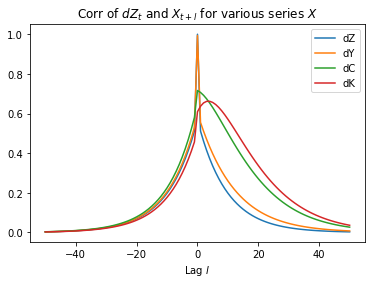

In [41]:
ls = np.arange(-50, 51)
corrs_l_positive = correl[:51, 0, :]
corrs_l_negative = correl[50:0:-1, :, 0]
corrs_combined = np.concatenate([corrs_l_negative, corrs_l_positive])

plt.plot(ls, corrs_combined[:, 0], label='dZ')
plt.plot(ls, corrs_combined[:, 1], label='dY')
plt.plot(ls, corrs_combined[:, 2], label='dC')
plt.plot(ls, corrs_combined[:, 3], label='dK')
plt.legend()
plt.title(r'Corr of $dZ_t$ and $X_{t+l}$ for various series $X$')
plt.xlabel(r'Lag $l$')
plt.show()

Here we can see many features of the solution. First, $dY$ is extremely similar to $dZ$, except that it has a greater lagged response due to capital accumulation. Both $dZ$ and $dY$ have a large peak at $l=0$ corresponding to the transitory shock. $dC$ and $dK$, on the other hand, are both much smoother and tend to lag $dZ$, especially $dK$.

## 6 Log-likelihood and estimation
The standard way to estimate linearized DSGE models is with a state space framework, calculating the log-likelihood for each set of parameters recursively using the Kalman filter. This becomes difficult with heterogeneous agent models where the relevant state space (even when reduced) may be quite high-dimensional, and the Kalman filter is costly to apply.

Fortunately, there is an alternative sequence-space approach to computing the log-likelihood, which directly evaluates the log-likelihood of the multivariate normal and bypasses the Kalman filter entirely. To our knowledge, this idea was introduced to the DSGE literature by [Mankiw and Reis (2007)](https://scholar.harvard.edu/files/mankiw/files/sticky_information.pdf), and until now has been confined to the literature on informational rigidities. We show that it is ideally suited for the estimation of heterogeneous-agent models, particularly given our ability to calculate many linear impulse responses quickly, and that we can implement it such that each evaluation of the log-likelihood takes only a few milliseconds.

### 6.1 Computation of log-likelihood
The key observation is that assuming the means of all series are zero (which is often imposed through some kind of preliminary demeaning or detrending procedure on the data), and that the shocks are multivariate normal, all we really need to evaluate the log-likelihood is the covariance matrix $\mathbf{V}_w$ of the vector of observations $\mathbf{w}$ used for estimation. Then we have (up to a constant):
$$\mathcal{L} = -\frac{1}{2}\log(\det(\mathbf{V}_w)) - \frac{1}{2}\mathbf{w}'\mathbf{V}_w^{-1}\mathbf{w} \tag{log-likelihood}$$ 
There are two key issues for implementation here: first, how to calculate $\mathbf{V}_w$ itself, and second, how to evaluate the log determinant and the quadratic form needed for the log-likelihood.

**Step 1: calculating $\mathbf{V}_w$**.
To avoid degeneracy and account for real-world data, we will generally assume that there is some measurement error, usually i.i.d.

If `Sigma` is a $T\times O \times O$ array with autocovariances between observable outcomes $O$ at each horizon up to $T$, and `sigmas_measure` is a length-$O$ array with the standard deviation of i.i.d. measurement error of each observable, and we have a time series of $\tau$ observations of each observable $O$, then the covariance matrix of the observations can be built using the following simple function, which is jitted using Numba for efficiency.

In [42]:
@njit
def build_full_covariance_matrix(Sigma, sigmas_measure, tau):
    """Takes in T*O*O array Sigma with covariances at each lag t,
       assembles them into (tau*O)*(tau*O) matrix of covariances, including measurement errors"""
    T, O, O = Sigma.shape
    V = np.empty((tau,O,tau,O))
    for t1 in range(tau):
        for t2 in range(tau):
            if abs(t1-t2) >= T:
                V[t1, : , t2, :] = np.zeros((O,O))
            else:
                if t1 < t2:
                    V[t1, : , t2, :] = Sigma[t2-t1, :, :]
                elif t1 > t2:
                    V[t1, : , t2, :] = Sigma[t1-t2, :, :].T
                else:
                    # want exactly symmetric
                    V[t1, : , t2, :] = (np.diag(sigmas_measure**2) 
                                        + (Sigma[0, :, :]+Sigma[0, :, :].T)/2)
    return V.reshape((tau*O, tau*O))

The `Sigma` itself, in turn, can be obtained given our solution using the methods from the previous section.

The explicit construction of $\mathbf{V}_w$ following this function may be somewhat costly and wasteful for large $\tau$, since the matrix is Toeplitz and does not contain any information that is not already in the (much smaller) inputs to the `build_full_covariance_matrix` function. Some methods for computing the log-likelihood do not require its explicit construction, but the simple one we'll use in step 2 does.

Let's apply this to the `Sigma` we calculated in section 5.2, assuming measurement error of 0.01 for all series and 100 observation periods. As we can see, it's fairly cheap:

In [43]:
V = build_full_covariance_matrix(Sigma, np.full(4, 0.01), 100) # burn-in
%time V = build_full_covariance_matrix(Sigma, np.full(4, 0.01), 100)
V.shape

CPU times: user 856 µs, sys: 516 µs, total: 1.37 ms
Wall time: 1.39 ms


(400, 400)

**Step 2: evaluating formula for $\mathcal{L}$.** Now, given $\mathbf{V}_w$, we must evaluate formula (log-likelihood). This requires computing the log determinant $\log(\det(\mathbf{V}_w))$ and the quadratic form $\mathbf{w}'\mathbf{V}_w^{-1}\mathbf{w}$.

The traditional, simplest way to do so is by obtaining a Cholesky decomposition of $\mathbf{V}_w$, as in the following function.

In [44]:
def log_likelihood(V, w):
    """Implements multivariate normal log-likelihood formula for observations w and variance V"""    
    V_factored = linalg.cho_factor(V)
    quadratic_form = np.dot(w, linalg.cho_solve(V_factored, w))
    log_determinant = 2*np.sum(np.log(np.diag(V_factored[0])))
    return -(log_determinant + quadratic_form)/2

Let's check out the evaluation speed for this given the `V` we just obtained, and random noise for the $4\times 100$ observations.

In [45]:
w = np.random.randn(400)
%time log_likelihood(V, w)

CPU times: user 10.8 ms, sys: 4.61 ms, total: 15.4 ms
Wall time: 16.6 ms


-1147957.3278134614

This is also quite fast: just a few milliseconds.

An alternative approach is to exploit the special block Toeplitz structure of $\mathbf{V}_w$ to obtain a block Cholesky decomposition using Levinson recursion. The time necessary for this grows with $\tau^2$ rather than $\tau^3$ in the ordinary Cholesky decomposition, but we have found in practical applications that Cholesky is implemented so efficiently that it dominates the Levinson approach except for larger $\tau$.

### 6.2 Putting it together: calculating the likelihood in an example
Continue to consider the shock process from section 5.2, where $dZ$ had one persistent component and one transitory component. Imagine that we do not know the persistence parameter $\rho$ of the persistent component, nor do we know the relative variances of these two shocks or the variances of the measurement errors. Given some observed data $\mathbf{w}$ with 100 observations of $dZ, dY, dC, dY$, what does the log-likelihood as a function of these parameters look like, and how do we compute it?

We write the following function.

In [46]:
def log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigmas_measure, w):
    # impulse response to persistent shock
    dZ1 = rho**(np.arange(T))
    dY1, dC1, dK1 = G['Y'] @ dZ1, G['c'] @ dZ1, G['K'] @ dZ1
    dX1 = np.stack([dZ1, dY1, dC1, dK1], axis=1)
    
    # since transitory shock does not depend on any unknown parameters,
    # except scale sigma_trans, we just reuse the dX2 already calculated earlier!
    
    # stack impulse responses together
    dX = np.stack([dX1, dX2], axis=2)
    
    # calculate all covariances
    Sigma = all_covariances(dX, np.array([sigma_persist, sigma_trans]), T)
    
    # build full covariance matrix for data
    V_w = build_full_covariance_matrix(Sigma, sigmas_measure, int(w.shape[0]/4))
    
    # calculate log-likelihood from this
    return log_likelihood(V_w, w)

Start with the parameters we've been using in sections 5.2 and 6.1:

In [47]:
rho = 0.9
sigma_persist = 0.01
sigma_trans = 0.04
sigmas_measure = np.full(4, 0.01)

and now see how long this full log-likelihood function takes to evaluate for a given parameter on random data:

In [48]:
w = np.random.randn(400)
%time log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigmas_measure, w)

CPU times: user 9.56 ms, sys: 2.18 ms, total: 11.7 ms
Wall time: 7.42 ms


-1163496.5721695295

It's just a few milliseconds for one log-likelihood computation! At this pace, full Bayesian estimation would be feasible within a matter of minutes on a personal laptop.

What is behind this speed? The key is the same as in section 4: once we have obtained the matrices in `G`, it is nearly free to compute the impulse responses to different shocks. This is extremely useful for estimation.

If we consider an alternative estimation exercise where we also estimate parameters of a model, rather than just the shock process, then computing the log-likelihood may become more difficult. There is an important case, however, where it is still mostly trivial: the case where we do not change parameters that affect the heterogeneous-agent blocks. In this case, we only need to compute the steady state and heterogeneous-agent Jacobian (which is the only nontrivial one) once, and solving the model for a change in other parameters is mostly still a simple matter of linear algebra.

This case has great appeal, since it is not clear there is much information in the time series to discipline the heterogeneous-agent steady state anyway.

**Simulate sample data.** Now let's simulate more realistic series $w=\{dZ, dY, dC, dK\}$, assuming the same parameters as above, to see what evaluating the log-likelihood is like. To do so, we simply use the variance matrix `V` calculated above.

In [49]:
w = np.random.multivariate_normal(np.zeros(400), V)

Now let's plot the log-likelihood of $w$ as a function of the standard deviation of the persistent component (the true value of which is 0.01), given correct values for all other parameters. Note that evaluating the log-likelihood 100 times takes well below one second.

In [50]:
sigma_persist_values = np.linspace(0.005, 0.02, 100)
%time lls = np.array([log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigmas_measure, w) for sigma_persist in sigma_persist_values])

CPU times: user 824 ms, sys: 114 ms, total: 938 ms
Wall time: 705 ms


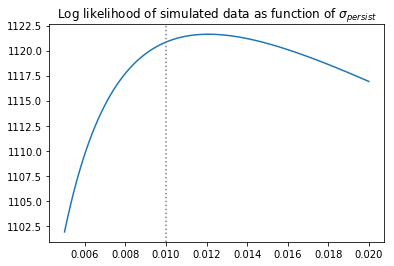

In [51]:
plt.plot(sigma_persist_values, lls)
plt.axvline(0.01, linestyle=':', color='gray')
plt.title(r'Log likelihood of simulated data as function of $\sigma_{persist}$')
plt.show()

Reassuringly, the mode is near (although not exactly at, since we're simulating a finite sample with only 100 periods) the value of $\sigma_{persist}=0.01$ with which the data was simulated!

## 7 Nonlinear dynamics
Linearized impulse responses are invariant to the sign and size of aggregate shocks by construction. Although this is not a problem for many applications, it is clearly a limitation. Here, we demonstrate that the Jacobian can also be extremely useful in solving for nonlinear dynamics.

Let us start by considering the case of an economy that starts at the steady state, and receives an unexpected shock at date 0. This is often called an "MIT shock". 

For a given shock $Z$, the solution is still characterized by the $K$ that solves $H(K,Z)=0$. Our algorithm to find this $K$, a simple variant of Newton's method, iterates on a sequence of guesses $K^j$ for the path of capital as follows:
1. starting with $j=0$, guess a path $K^0$
2. calculate $H(K^j, Z)$
3. update the guess according to $$K^{j+1} = K^j - H_K(K_{ss}, Z_{ss})^{-1} H(K^j, Z)$$
and return to step 2 for $j+1$

The only difference between this and the standard Newton's method is that we use the Jacobian $H_K$ around the steady state (which we have already calculated), rather than the Jacobian around the current guess (which is somewhat more difficult to calculate). Still, this tends to achieve extremely fast convergence.

Although iterative methods to solve for equilibrium in response to MIT shocks are quite common in the heterogeneous-agent literature, these methods generally use ad-hoc rules for updating the guess, which can be fragile and slow. In applications with no or limited heterogeneity (such as spender-saver models) where it is possible to calculate Jacobians easily, Newton's method has been used to provide faster and more robust convergence -- see, for instance, [Juillard (1996)](http://www.cepremap.fr/depot/couv_orange/co9602.pdf).

But until now, this has not been applied to heterogeneous-agent models, since the Jacobian has been too difficult to calculate. The only partial applications to date, to our knowledge, are in [Auclert and Rognlie (2018)](http://web.stanford.edu/~aauclert/computational_appendix_inequad.pdf), which uses an auxiliary model to compute an approximate Jacobian, and in [Straub (2018)](https://scholar.harvard.edu/files/straub/files/jmp_straub_jan_2.pdf), which uses interpolation to compute an approximate Jacobian. In this paper, however, we have provided a highly efficient method to compute the *exact* Jacobian around the steady state for any heterogeneous-agent model, and can thus readily apply Newton's method.

### 7.1 Algorithm
First we need functions that can evaluate the building blocks of $H(K,Z)$, the firm block and household block, nonlinearly for arbitrary inputs.

Since some of the details are slighly tedious, we relegate the function `household_td` to the module `ks.py`. This function, which performs a backward iteration to get policies and a forward iteration to update the distribution, is called by providing the steady state and then specifying the path of any input that deviates from the steady state.

By using the decorator `@recursive`, we have already enabled the firm block to evaluate itself on any path by using the method `.td()`.

Combining these, it is easy to write the function $H(K,Z)$ below as `td_map`, which takes in the steady state and paths for $K$ and $Z$ and returns the asset market clearing discrepancy. It also returns, in `td`, paths for $r,w,K,Z,Y$ and household variables that are calculated along the way.

In [52]:
def td_map(ss, K, Z):
    # firm block
    r, w, Y = firm.td(ss, K=K, Z=Z)

    # ha block
    td = ks.household_td(ss, r=r, w=w)
    td.update({'r': r, 'w': w, 'K': K, 'Z': Z, 'Y': Y})

    return td['A'] - K, td

Now we can run Newton's method, given $H_K^{-1}$. Once a path $K$ is found such that asset market clearing holds, we return the dict `td` with all paths.

In [53]:
def td_nonlinear(ss, H_K_inv, Z, tol=1E-8, maxit=30, noisy=True):
    """Compute non-linear impulse response via Newton's method."""
    # initialize guess at ss
    T = Z.shape[0]
    K = np.full(T, ss['K'])

    # iterate until convergence
    for it in range(maxit):
        asset_mkt, td = td_map(ss, K, Z)
        error = np.max(np.abs(asset_mkt))
        if noisy:
            print(f'Max error {error:.2E} on iteration {it}')
        if error < tol:
            break
        else:
            K -= H_K_inv @ asset_mkt
    else:
        raise ValueError(f'No convergence after {maxit} backward iterations!')

    return td

### 7.2 Results
Let's apply this to a productivity shock that increases $Z$ by 1% on impact, with a persistence of 0.8.

In [54]:
H_K_inv = np.linalg.inv(H_K)
Z = ss['Z'] + 0.01*0.8**np.arange(T)
%time td_nonlin = td_nonlinear(ss, H_K_inv, Z)

Max error 3.67E-02 on iteration 0
Max error 9.29E-05 on iteration 1
Max error 1.11E-07 on iteration 2
Max error 9.62E-11 on iteration 3
CPU times: user 200 ms, sys: 8.47 ms, total: 208 ms
Wall time: 121 ms


We see that this is quite quick, taking only 3 iterations after the initial guess to achieve high accuracy -- far fewer than typical ad-hoc updating rules, which can take hundreds or thousands of iterations.

Now let's compare to the results we'd get for the linearized impulse response, and plot the paths for the real interest rate $r$.

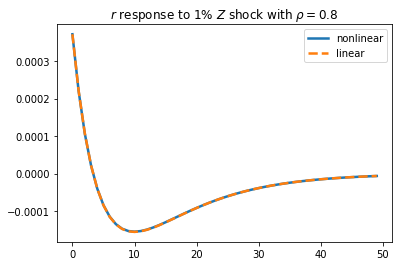

In [55]:
dr_nonlin = td_nonlin['r'] - ss['r']
dr_lin = G['r'] @ (Z - ss['Z'])
plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'$r$ response to 1% $Z$ shock with $\rho=0.8$')
plt.legend()
plt.show()

There is no visible difference -- the first-order approximation is almost perfect here.

If we increase the size of the productivity shock on impact to 10% (enormous!), we can begin to see small nonlinearities kick in, and the solution requires five iterations rather than three:

Max error 3.76E-01 on iteration 0
Max error 8.81E-03 on iteration 1
Max error 1.19E-04 on iteration 2
Max error 9.94E-07 on iteration 3
Max error 1.21E-08 on iteration 4
Max error 3.22E-10 on iteration 5


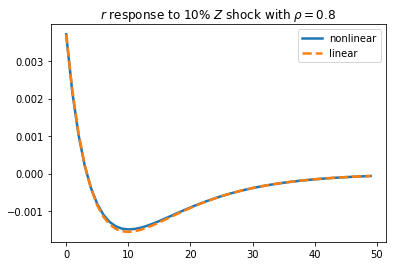

In [56]:
Z = ss['Z'] + 0.1*0.8**np.arange(T)
td_nonlin = td_nonlinear(ss, H_K_inv, Z)
dr_nonlin = td_nonlin['r'] - ss['r']
dr_lin = G['r'] @ (Z - ss['Z'])
plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'$r$ response to 10% $Z$ shock with $\rho=0.8$')
plt.legend()
plt.show()